<a href="https://colab.research.google.com/github/vtsimoes/class_victor_dataset/blob/main/G_Linear_Classifiers_Dataset_VICTOR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Aplicação de Classificadores Lineares no Dataset VICTOR
---

In [ ]:
#carregamento das bibliotecas utilizadas
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
import pandas as pd
import seaborn as sns
import numpy as np
from google.colab import drive
import re
import pickle
import time
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#from sklearn.metrics import plot_confusion_matrix
import psutil
import os

#1. O DATASET
Link para solicitação do Dataset: https://ailab.unb.br/victor/lrec2020

Linka para o artigo que disponibilizou o dataset: https://aclanthology.org/2020.lrec-1.181.pdf [1]

O dataset consiste de 692.966 documentos jurídicos da base do Supremo tribunal Federal (STF), sendo 628.820 rotulados em 6 categorias: Acórdão, Recurso Extraordinário, Agravo de Recurso Extraordinário, Despacho, Sentença e Outros.

O Dataset possui 3 versões: Maior (BVic), médio (MVic) e menor (SVic). A Tabela abaixo mostra a distribuição do número de documentos em cada categoria.

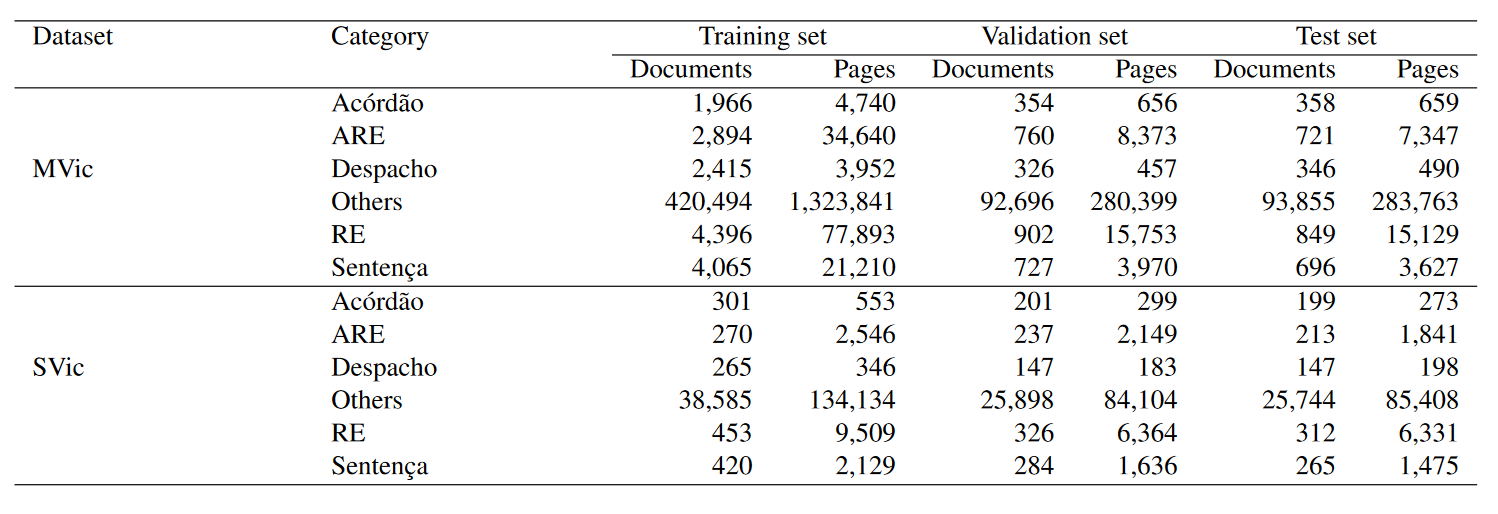

Em virtude da quantidade de documentos ser grande, mesmo no conjunto menor, vamos trabalhar com uma versão reduzida do SVic, onde serão utilizadas apenas as categorias rotuladas, excluindo os documentos categorizados como "Outros", do conjunto de treino, assim ficamos com um dataset com 5 classes e 1.702 exemplos.

##Paths dos experimentos



In [ ]:
path_rl = '' #path para resultados da Regressão Logística
path_svm = '' #path para resultados do SVM
#Montando o google drive para obter os dados
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
def path_model(calssificador,path_rl,path_svm):
  if CLASSIFICADOR == 'LR':
    path_results = os.path.join(path_rl,NOME_RUNNING)
    model = LogisticRegression()
  else:
    path_results = os.path.join(path_svm,NOME_RUNNING)
    model = SVC(kernel='linear')
  if not os.path.exists(path_results):
    os.makedirs(path_results)
  return path_results,model

In [ ]:
def save_pickle(data_to_save,path='',filename='file.pkl'):
  open_file = open(os.path.join(path,filename), "wb")
  pickle.dump(data_to_save, open_file)
  open_file.close()

def load_pickle(path='',filename='file.pkl'):
  open_file = open(path + filename, "rb")
  pkl_file = pickle.load(open_file)
  open_file.close()
  return pkl_file

## Funções para Seleção de Parâmetros, treinamento do modelo e exibição de resultados.

In [ ]:
from sklearn.metrics import matthews_corrcoef

In [ ]:
from scipy.sparse import vstack
def concat_train_valid(train,valid,vector_name):
  result = {vector_name:vstack((train[vector_name],valid[vector_name])),'labels':np.concatenate((train['labels'],valid['labels']))}
  return result

In [ ]:
#Função para treinamento do modelo utilizando GridSearch com cross-validation, e apresentação dos resultados com o conjunto de teste para o melhor modelo.
def gridSerach(train_text,train_label,test_text,test_label,parameters,model=SVC(),cv=5,verbose=2):
  tic = time.perf_counter()
  #classes = train_label.unique()
  classes = list(set(train_label))
  clf = GridSearchCV(model,parameters,scoring='f1_macro',cv=cv,return_train_score=True,verbose=verbose,n_jobs=-1)
  clf.fit(train_text,train_label)
  toc = time.perf_counter()
  y_pred = clf.best_estimator_.predict(test_text)

  confusion = confusion_matrix(test_label, y_pred)

  f1score = f1_score(test_label, y_pred,average='macro')
  scores = precision_recall_fscore_support(test_label, y_pred,average=None)
  fig, ax = plt.subplots(figsize=(10, 10))
  print("Matriz de confusão para o conjunto de teste aplicado ao melhor modelo.")
  ConfusionMatrixDisplay.from_predictions(test_label,y_pred,display_labels=clf.best_estimator_.classes_,values_format='.2f',normalize='true',ax=ax,xticks_rotation='vertical')
  report = classification_report(test_label,y_pred,labels=clf.best_estimator_.classes_,digits=5)
  report_as_dict = classification_report(test_label,y_pred,labels=clf.best_estimator_.classes_,digits=5,output_dict=True)
  mcc_test = matthews_corrcoef(test_label,y_pred)

  time_process = toc - tic
  #saveModelResults(clf,confusion,f1score,scores,time_process,classes,report,filename=filename,path=path)
  return clf,confusion,f1score,scores,time_process,classes,report,mcc_test,report_as_dict,y_pred,test_label

In [ ]:
def saveModelResults(clfsvc,conf,f1,scores,time,classes,report,mcc,experimento,report_as_dicts,path,y_pred,y_true,tipo="results"):
  score = {'clf':clfsvc,'confusion':conf,'f1score':f1,'scores':scores,'mcc_test':mcc,'time':time,'report':report, 'report_as_dict':report_as_dicts,'experimento': experimento,'classes':classes,'y_pred':y_pred,'y_true':y_true}
  filename = tipo+'.pkl'
  save_pickle(score,path=path,filename=filename)

In [ ]:
def print_results(report,f1,clf,mcc_test,time_process):
  print(report)
  print("F1-score Médio de Teste : " + str(f1))
  print("MCC de Teste: " + str(mcc_test))
  print("Tempo de processamento total: " + str(time_process) + ' s')
  if isinstance(clf,GridSearchCV):
    print("Melhores parâmteros: " + str(clf_grid.best_params_))
    print("Tempo de processamento médio para treinamento: " + str(clf_grid.cv_results_['mean_fit_time'][0]) + ' s')

In [ ]:
def execute_best_model(train_text,train_label,test_text,test_label,parameters,model=SVC()):

  #classes = train_label.unique()
  classes = list(set(train_label))
  clf = model
  clf.set_params(**parameters)
  tic = time.perf_counter()
  clf.fit(train_text,train_label)
  toc = time.perf_counter()

  tic_infer = time.perf_counter()
  y_pred = clf.predict(test_text)
  toc_infer = time.perf_counter()

  confusion = confusion_matrix(test_label, y_pred)

  f1score = f1_score(test_label, y_pred,average='macro')
  scores = precision_recall_fscore_support(test_label, y_pred,average=None)
  fig, ax = plt.subplots(figsize=(10, 10))
  print("Matriz de confusão para o conjunto de teste aplicado ao melhor modelo.")
  ConfusionMatrixDisplay.from_predictions(test_label,y_pred,display_labels=clf.classes_,values_format='.2f',normalize='true',ax=ax,xticks_rotation='vertical')
  report = classification_report(test_label,y_pred,labels=clf.classes_,digits=5)
  report_as_dict = classification_report(test_label,y_pred,labels=clf.classes_,digits=5,output_dict=True)
  mcc_test = matthews_corrcoef(test_label,y_pred)

  time_process = {'train': toc - tic,'infer': (toc_infer - tic_infer)/len(test_label)}  #saveModelResults(clf,confusion,f1score,scores,time_process,classes,report,filename=filename,path=path)
  return clf,confusion,f1score,scores,time_process,classes,report,mcc_test,report_as_dict,y_pred,test_label

Antes de começar os experimentos, executar até aqui

## Experimentos com TF-IDF

In [ ]:
## Definição do nome do Experimento
CLASSIFICADOR = 'LR'
TRANSFORM = 'TF_IDF'
VOCAB = '70K'
TF_IDF_TYPE = 'SMALL'
GRAM = 'BI'
DATASET = 'O100'
NOME_RUNNING = f'{CLASSIFICADOR}-{TRANSFORM}-{TF_IDF_TYPE}-{VOCAB}-{GRAM}-{DATASET}'
NOME_RUNNING

'LR-TF_IDF-SMALL-70K-BI-O100'

### Carregando documentos transformados

In [ ]:
#Paths com os dados transformados, e para salvamento dos resultados
path_transformados = '' #path com os dados transformados TF-IDF
path_results,model = path_model(CLASSIFICADOR,path_rl,path_svm)
path_results

In [ ]:
#Nomes dos arquivos com as transformações TF-IDF
train_filename = ''
valid_filename = ''
test_filename = ''
train_filename,valid_filename,test_filename

In [ ]:
train_tf_idf = load_pickle(path=path_transformados,filename=train_filename)
valid_tf_idf = load_pickle(path=path_transformados,filename=valid_filename)
test_tf_idf = load_pickle(path=path_transformados,filename=test_filename)

In [ ]:
train_tf_idf['vector'].shape,valid_tf_idf['vector'].shape,test_tf_idf['vector'].shape

((38814, 70000), (25448, 70000), (25300, 70000))

In [ ]:
train_valid_tf_idf = concat_train_valid(train_tf_idf,valid_tf_idf,'vector') # juntando treino e validação para usar na seleção de parâmetros

### Executando Seleção de Parâmetro

In [ ]:
parameters = {'C':[10, 100, 1000]}
clf_grid,confusion,f1,scores,time_process,classes,report,mcc_test,report_as_dict,y_pred,y_true = gridSerach(train_valid_tf_idf['vector'],train_valid_tf_idf['labels'],test_tf_idf['vector'],test_tf_idf['labels'],parameters,model=model)

In [ ]:
saveModelResults(clf_grid,confusion,f1,scores,time_process,classes,report,mcc_test,NOME_RUNNING,report_as_dict,path_results,y_pred,y_true,'grid_search')

In [ ]:
print_results(report,f1,clf_grid,mcc_test,time_process)

### Executanto melhor conjunto de parâmetros para conjunto de treino e test

In [ ]:
clf,confusion,f1,scores,time_process,classes,report,mcc_test,report_as_dict,y_pred,y_true = execute_best_model(train_tf_idf['vector'],train_tf_idf['labels'],test_tf_idf['vector'],test_tf_idf['labels'],clf_grid.best_params_,model=model)

In [ ]:
saveModelResults(clf_grid,confusion,f1,scores,time_process,classes,report,mcc_test,NOME_RUNNING,report_as_dict,path_results,y_pred,y_true,'results')
print_results(report,f1,clf,mcc_test,time_process)

## Experimentos com Word2Vec, FastText ou BERT

### Carregando os Dados

In [ ]:
## Definição do nome do Experimento
CLASSIFICADOR = 'SVM'
TRANSFORM = 'bert'
EMBD_SIZE = '768' # tamanho do vetor de embedding
EMBD_TYPE = 'SPECIALIZED' # Tipo do Embedding: Genérico (GEN) ou Especializado (ESP)
SEQ_LEN = '512' # quantidade de tokens usados na geração da representação do documento
GRAM = 'UNI'
DATASET = 'O100'
#C = '100'
NOME_RUNNING = f'{CLASSIFICADOR}-{TRANSFORM}-{EMBD_SIZE}-{EMBD_TYPE}-{SEQ_LEN}-{GRAM}-{DATASET}'
NOME_RUNNING

'SVM-bert-768-SPECIALIZED-512-UNI-O100'

### Indicar os path onde estão os dados transformados, de acordo com o tipo

In [ ]:
path_transformados = ''
path_results,model = path_model(CLASSIFICADOR,path_rl,path_svm)
path_results,path_transformados

In [ ]:
#Nomes dos arquivos com as transformações Word2Vec, FastText ou BERT
train_filename = ''
valid_filename = ''
test_filename = ''
train_filename,valid_filename,test_filename

In [ ]:
train_w2v = load_pickle(path=path_transformados,filename=train_filename)
valid_w2v = load_pickle(path=path_transformados,filename=valid_filename)
test_w2v = load_pickle(path=path_transformados,filename=test_filename)

### AS duas próximas células usar apenas quando o BERT

In [ ]:
def transform_tensor_to_array(data):
  docs = [y.cpu().detach().numpy() for train in data['w2v'] for y in train]
  return np.array(docs)

In [ ]:
train_w2v['w2v'] = transform_tensor_to_array(train_w2v)
valid_w2v['w2v'] = transform_tensor_to_array(valid_w2v)
test_w2v['w2v'] = transform_tensor_to_array(test_w2v)
train_w2v['w2v'].shape,valid_w2v['w2v'].shape,test_w2v['w2v'].shape

### Executando Seleção de Parâmetro

In [ ]:
train_valid_w2v = concat_train_valid(train_w2v,valid_w2v,'w2v') # juntando treino e validação para usar na seleção de parâmetros

In [ ]:
parameters = {'C':[10, 100, 1000]}
clf_grid,confusion,f1,scores,time_process,classes,report,mcc_test,report_as_dict,y_pred,y_true = gridSerach(train_valid_w2v['w2v'],train_valid_w2v['labels'],test_w2v['w2v'],test_w2v['labels'],parameters,model=model,verbose=4)

In [ ]:
saveModelResults(clf_grid,confusion,f1,scores,time_process,classes,report,mcc_test,NOME_RUNNING,report_as_dict,path_results,y_pred,y_true,'grid_search')

In [ ]:
print_results(report,f1,clf_grid,mcc_test,time_process)

### Executanto melhor conjunto de parâmetros para conjunto de treino e test

In [ ]:
clf,confusion,f1,scores,time_process,classes,report,mcc_test,report_as_dict,y_pred,y_true = execute_best_model(train_w2v['w2v'],train_w2v['labels'],test_w2v['w2v'],test_w2v['labels'],{'C':10},model=model)

In [ ]:
saveModelResults(clf,confusion,f1,scores,time_process,classes,report,mcc_test,NOME_RUNNING,report_as_dict,path_results,y_pred,y_true,'results')

In [ ]:
print_results(report,f1,clf,mcc_test,time_process)